In [28]:
import os
import s3fs

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

In [29]:
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})

BUCKET = "fabienhos"
FILE_KEY_S3 = "deaths_france/valeurs_mensuelles.csv"
FILE_PATH_S3 = BUCKET + "/" + FILE_KEY_S3

with fs.open(FILE_PATH_S3, mode="rb") as file_in:
    df = pd.read_csv(file_in, sep=";")

In [30]:
df['period'] = pd.to_datetime(df['period'], format="%Y-%m")
df = df.sort_values('period').set_index('period')

df

,values
period,
1946-01-01,70900
1946-02-01,53958
1946-03-01,57287
1946-04-01,45376
1946-05-01,42591
...,...
2025-01-01,69300
2025-02-01,54800
2025-03-01,53900


In [4]:
df.dtypes

values    int64
dtype: object

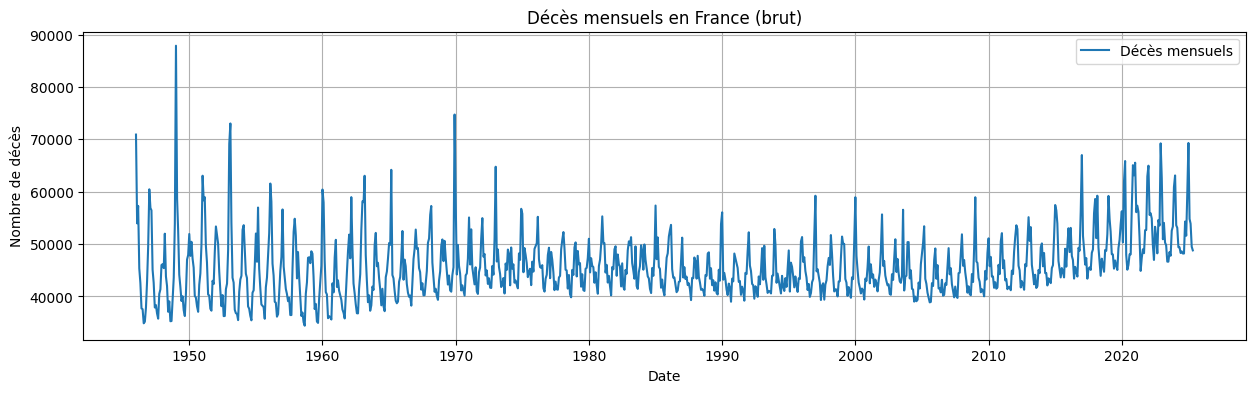

Valeurs manquantes : 0
Doublons : 0


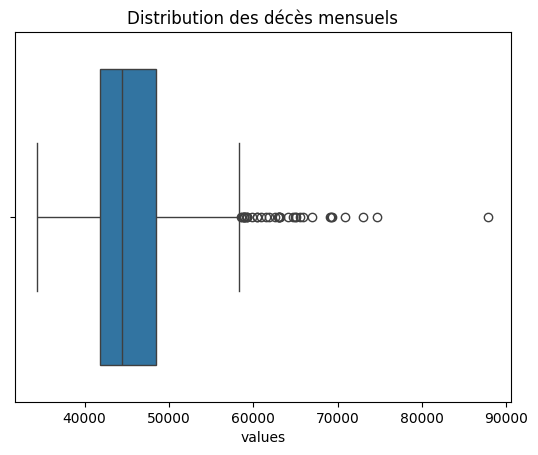

In [7]:
# Visualisation brute
plt.figure(figsize=(15, 4))
plt.plot(df['values'], label='Décès mensuels')
plt.title("Décès mensuels en France (brut)")
plt.xlabel("Date")
plt.ylabel("Nombre de décès")
plt.grid(True)
plt.legend()
plt.show()

# Valeurs manquantes ou anomalies
print("Valeurs manquantes :", df['values'].isna().sum())
print("Doublons :", df.index.duplicated().sum())

# Détection outliers simples
sns.boxplot(x=df['values'])
plt.title("Distribution des décès mensuels")
plt.show()


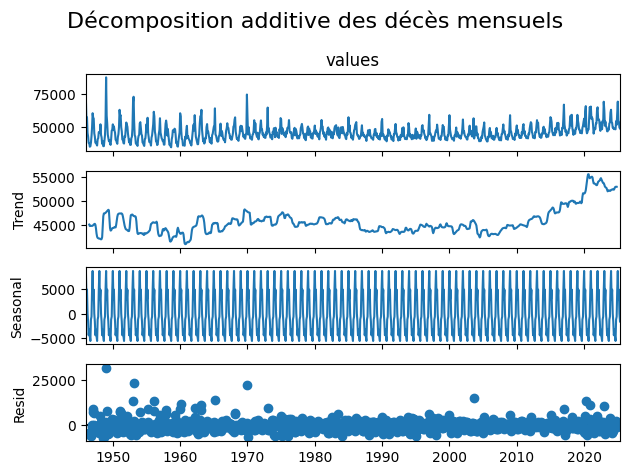

In [8]:
result = seasonal_decompose(df['values'], model='additive', period=12)

# Affichage des composantes
result.plot()
plt.suptitle("Décomposition additive des décès mensuels", fontsize=16)
plt.tight_layout()
plt.show()

In [9]:
# Test de stationnarité (Dickey-Fuller)
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(df['values'])
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print(f"""
H0 : la série n'est pas stationnaire 
H1 : la série est stationnaire 
""")

if adf_result[1] > 0.05 :
    print("On ne peut pas rejeter H0")
else:
    print("On rejette H0")

ADF Statistic: -1.2935167107845846
p-value: 0.6321331819067899

H0 : la série n'est pas stationnaire 
H1 : la série est stationnaire 

On ne peut pas rejeter H0


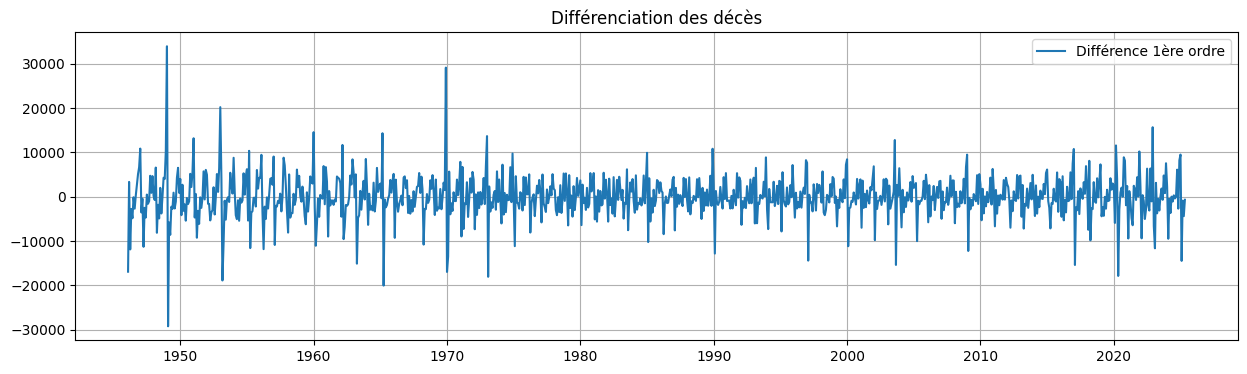

In [10]:
# Différenciation
df['diff'] = df['values'].diff()

plt.figure(figsize=(15, 4))
plt.plot(df['diff'], label="Différence 1ère ordre")
plt.title("Différenciation des décès")
plt.grid(True)
plt.legend()
plt.show()

In [11]:
df2 = df.dropna()

In [12]:
adf_result2 = adfuller(df2['diff'])
print(f"ADF Statistic: {adf_result2[0]}")
print(f"p-value: {adf_result2[1]}")
print(f"""
H0 : la série n'est pas stationnaire 
H1 : la série est stationnaire 
""")

if adf_result2[1] > 0.05 :
    print("On ne peut pas rejeter H0")
else:
    print("On rejette H0")

ADF Statistic: -16.37875874166203
p-value: 2.7646384117764626e-29

H0 : la série n'est pas stationnaire 
H1 : la série est stationnaire 

On rejette H0


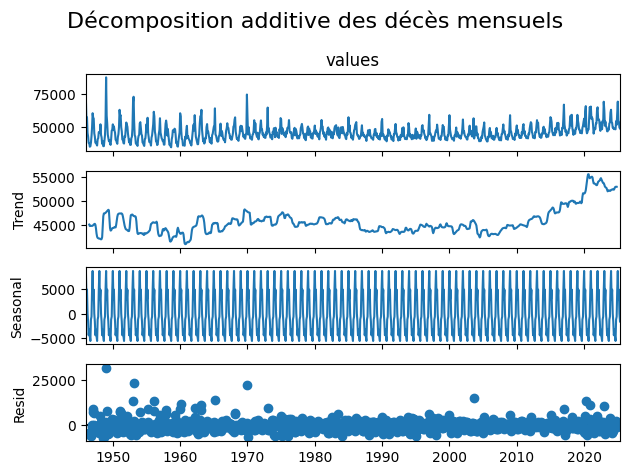

In [13]:
result2 = seasonal_decompose(df2['diff'], model='additive', period=12)

# Affichage des composantes
result.plot()
plt.suptitle("Décomposition additive des décès mensuels", fontsize=16)
plt.tight_layout()
plt.show()

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

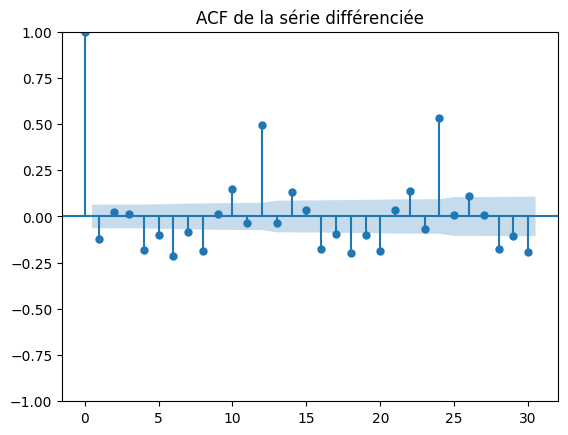

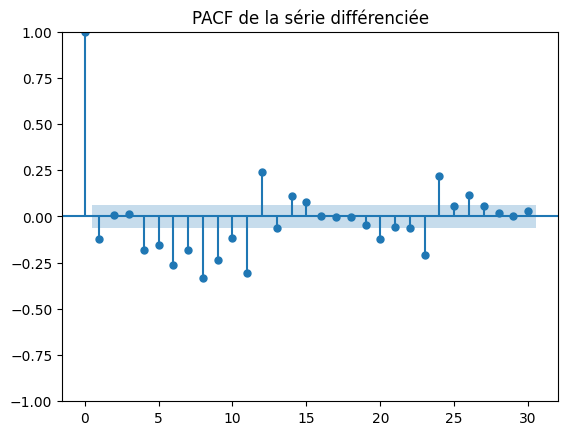

In [15]:
# ACF / PACF pour déterminer p et q
plot_acf(df['diff'].dropna(), lags=30)
plt.title("ACF de la série différenciée")
plt.show()

plot_pacf(df['diff'].dropna(), lags=30)
plt.title("PACF de la série différenciée")
plt.show()

In [16]:
df2

,values,diff
period,,
1946-02-01,53958,-16942.0
1946-03-01,57287,3329.0
1946-04-01,45376,-11911.0
1946-05-01,42591,-2785.0
1946-06-01,37721,-4870.0
...,...,...
2025-01-01,69300,9500.0
2025-02-01,54800,-14500.0
2025-03-01,53900,-900.0


In [17]:
df2 = df2.sort_index()
df2 = df2.asfreq('MS')


In [ ]:

# 90% pour entraînement, 10% pour test
train_size = int(len(df2) * 0.9)
train, test = df2.iloc[:train_size], df.iloc[train_size:]

In [ ]:
# ARIMA entraîné sur train uniquement
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train['values'], order=(1, 1, 1))
model_fit = model.fit()

In [32]:
# Prédiction sur la même période que le test
forecast = model_fit.forecast(steps=len(test))

MAE: 47682.39


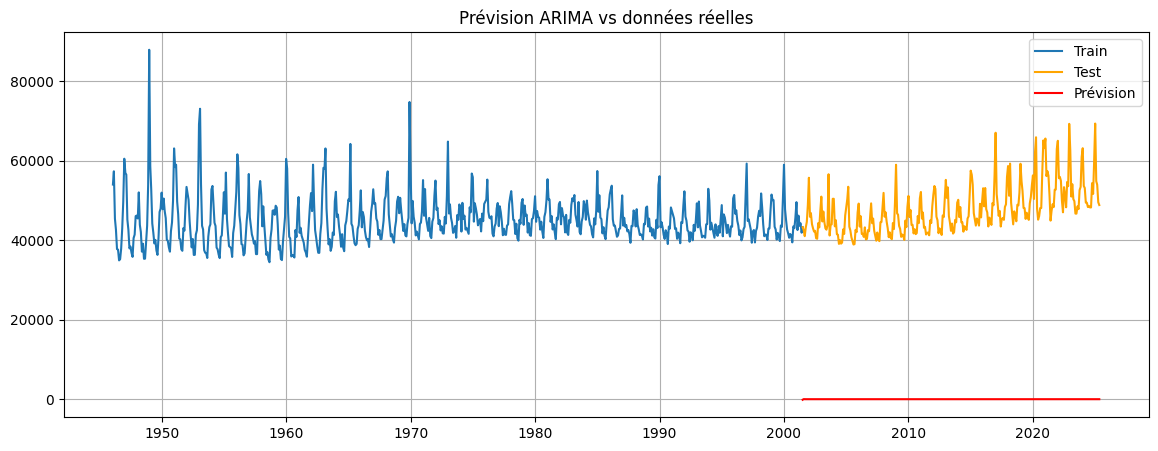

In [33]:
# Évaluation
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(test['values'], forecast)
print(f"MAE: {mae:.2f}")

plt.figure(figsize=(14, 5))
plt.plot(train.index, train['values'], label='Train')
plt.plot(test.index, test['values'], label='Test', color='orange')
plt.plot(test.index, forecast, label='Prévision', color='red')
plt.legend()
plt.title("Prévision ARIMA vs données réelles")
plt.grid(True)
plt.show()

In [52]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Définir les ordres SARIMA (p,d,q) et (P,D,Q,s) pour la composante saisonnière
order = (1, 1, 1)          # ordre non-saisonnier (p, d, q)
seasonal_order = (1, 1, 1, 12)  # ordre saisonnier (P, D, Q, s) où s est la périodicité (12 pour des données mensuelles)

# Créer et ajuster le modèle SARIMA
model = SARIMAX(train['values'], 
                order=order, 
                seasonal_order=seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False)

model_fit = model.fit(disp=False)  # disp=False pour réduire la sortie

# Afficher le résumé du modèle
print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                             values   No. Observations:                  856
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -7932.212
Date:                            Sat, 19 Jul 2025   AIC                          15874.424
Time:                                    21:13:04   BIC                          15898.025
Sample:                                02-01-1946   HQIC                         15883.475
                                     - 05-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4303      0.028     15.326      0.000       0.375       0.485
ma.L1         -0.9896      0.018   

In [ ]:
# Prédiction sur la même période que le test
forecast = model_fit.forecast(steps=len(test))

In [54]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(test['values'], forecast)
print(f"MAE: {mae:.2f}")

plt.figure(figsize=(14, 5))
plt.plot(train.index, train['values'], label='Train')
plt.plot(test.index, test['values'], label='Test', color='orange')
plt.plot(test.index, forecast, label='Prévision', color='red')
plt.legend()
plt.title("Prévision ARIMA vs données réelles")
plt.grid(True)
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [97, 12]

MAE: 2851.80


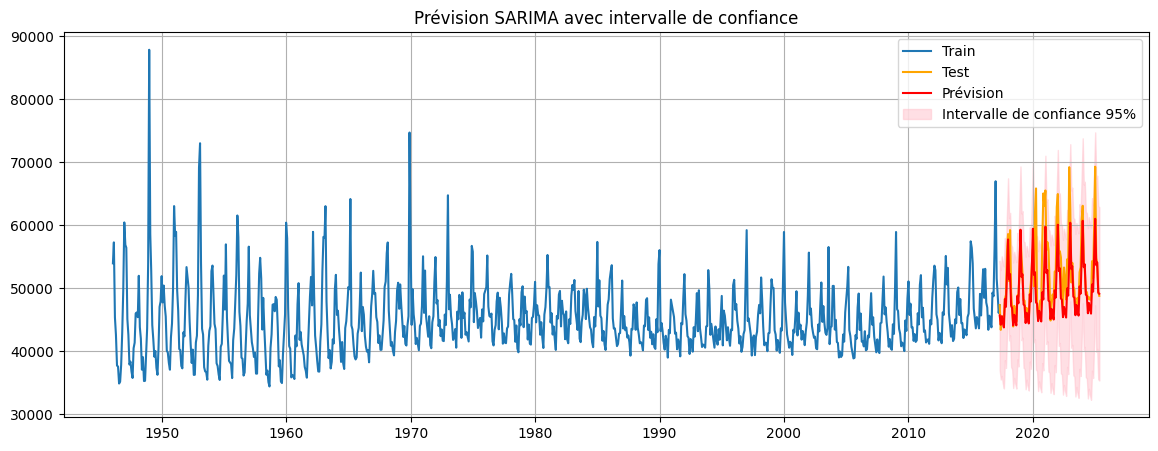

In [50]:
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Obtenir les prévisions avec intervalle de confiance
predictions = model_fit.get_prediction(start=test.index[0], end=test.index[-1], dynamic=False)
forecast = predictions.predicted_mean
conf_int = predictions.conf_int()  # Intervalle de confiance à 95%

# Calcul du MAE
mae = mean_absolute_error(test['values'], forecast)
print(f"MAE: {mae:.2f}")

# Visualisation
plt.figure(figsize=(14, 5))
plt.plot(train.index, train['values'], label='Train')
plt.plot(test.index, test['values'], label='Test', color='orange')
plt.plot(test.index, forecast, label='Prévision', color='red')

# Ajout de l'intervalle de confiance
plt.fill_between(test.index, 
                conf_int.iloc[:, 0], 
                conf_int.iloc[:, 1], 
                color='pink', alpha=0.5, label='Intervalle de confiance 95%')

plt.legend()
plt.title("Prévision SARIMA avec intervalle de confiance")
plt.grid(True)
plt.show()

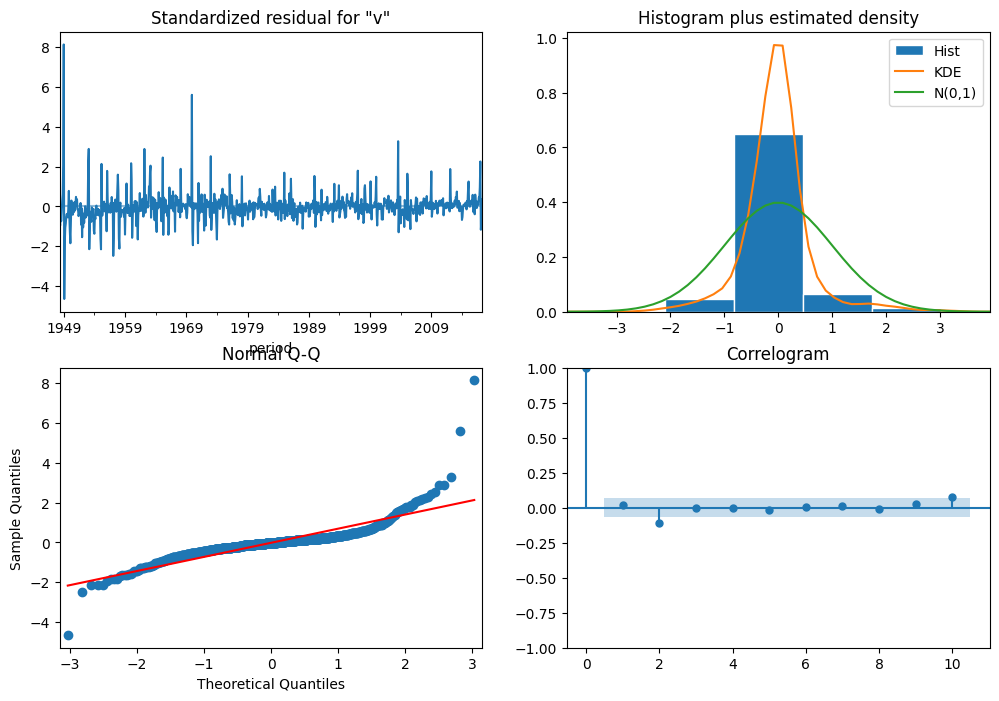

In [55]:
model_fit.plot_diagnostics(figsize=(12, 8))
plt.show()

In [63]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Test sur plusieurs lags avec affichage complet
lb_test = acorr_ljungbox(model_fit.resid, lags=[5, 10, 15], return_df=True)
print("\nTest de Ljung-Box:")
print(lb_test)

# Interprétation :
print("\nInterprétation:")
print("Toutes les p-values > 0.05 indiquent des résidus non corrélés")


Test de Ljung-Box:
      lb_stat  lb_pvalue
5    9.476544   0.091501
10  33.061920   0.000266
15  45.331810   0.000068

Interprétation:
Toutes les p-values > 0.05 indiquent des résidus non corrélés


In [19]:
import pmdarima
print(f"Version installée : {pmdarima.__version__}")

Version installée : 2.0.4


In [20]:
from pmdarima import auto_arima
best_model = auto_arima(train['values'],
                        seasonal=True,
                        m=12,  # Périodicité saisonnière
                        stepwise=True,
                        trace=True,
                        error_action='ignore')

/home/onyxia/work/forecast_deaths_france/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onyxia/work/forecast_deaths_france/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onyxia/work/forecast_deaths_france/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onyxia/work/forecast_deaths_france/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onyxia/work/forecast_deaths_france/.venv/lib/python3.12/site-packages/

Performing stepwise search to minimize aic


 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=3.82 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=17156.368, Time=0.04 sec


/home/onyxia/work/forecast_deaths_france/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onyxia/work/forecast_deaths_france/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=16542.358, Time=0.88 sec


/home/onyxia/work/forecast_deaths_france/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=16659.219, Time=0.62 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=20784.817, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=16742.119, Time=0.06 sec


/home/onyxia/work/forecast_deaths_france/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onyxia/work/forecast_deaths_france/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/onyxia/work/forecast_deaths_france/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=16477.121, Time=3.71 sec


/home/onyxia/work/forecast_deaths_france/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=16444.739, Time=2.49 sec


/home/onyxia/work/forecast_deaths_france/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.86 sec


/home/onyxia/work/forecast_deaths_france/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(2,0,2)[12] intercept   : AIC=inf, Time=6.03 sec


/home/onyxia/work/forecast_deaths_france/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=inf, Time=7.52 sec


/home/onyxia/work/forecast_deaths_france/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=3.30 sec


/home/onyxia/work/forecast_deaths_france/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(2,0,1)[12] intercept   : AIC=16434.246, Time=3.89 sec


/home/onyxia/work/forecast_deaths_france/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=nan sec


/home/onyxia/work/forecast_deaths_france/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=16406.897, Time=13.64 sec


/home/onyxia/work/forecast_deaths_france/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=16534.007, Time=1.39 sec


/home/onyxia/work/forecast_deaths_france/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(2,0,0)[12] intercept   : AIC=16484.418, Time=7.30 sec


/home/onyxia/work/forecast_deaths_france/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(2,0,0)[12] intercept   : AIC=16386.813, Time=12.90 sec


/home/onyxia/work/forecast_deaths_france/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(1,0,0)[12] intercept   : AIC=16481.197, Time=1.90 sec


/home/onyxia/work/forecast_deaths_france/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(2,0,1)[12] intercept   : AIC=16386.522, Time=7.11 sec


/home/onyxia/work/forecast_deaths_france/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=1.45 sec


/home/onyxia/work/forecast_deaths_france/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(2,0,2)[12] intercept   : AIC=inf, Time=7.84 sec


/home/onyxia/work/forecast_deaths_france/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(1,0,2)[12] intercept   : AIC=inf, Time=16.81 sec


/home/onyxia/work/forecast_deaths_france/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(2,0,1)[12] intercept   : AIC=16403.005, Time=3.39 sec


/home/onyxia/work/forecast_deaths_france/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(2,0,1)[12] intercept   : AIC=16373.866, Time=11.12 sec


/home/onyxia/work/forecast_deaths_france/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=2.63 sec


/home/onyxia/work/forecast_deaths_france/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(2,0,0)[12] intercept   : AIC=16371.702, Time=19.94 sec


/home/onyxia/work/forecast_deaths_france/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(1,0,0)[12] intercept   : AIC=inf, Time=2.47 sec


/home/onyxia/work/forecast_deaths_france/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,1)(2,0,0)[12] intercept   : AIC=16374.878, Time=19.45 sec


/home/onyxia/work/forecast_deaths_france/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(2,0,0)[12] intercept   : AIC=16331.752, Time=15.17 sec


/home/onyxia/work/forecast_deaths_france/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(1,0,0)[12] intercept   : AIC=inf, Time=1.80 sec


/home/onyxia/work/forecast_deaths_france/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(2,0,1)[12] intercept   : AIC=16333.194, Time=11.91 sec


/home/onyxia/work/forecast_deaths_france/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=3.26 sec


/home/onyxia/work/forecast_deaths_france/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(2,0,0)[12] intercept   : AIC=inf, Time=10.52 sec


/home/onyxia/work/forecast_deaths_france/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,2)(2,0,0)[12] intercept   : AIC=16324.340, Time=17.21 sec


/home/onyxia/work/forecast_deaths_france/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,2)(1,0,0)[12] intercept   : AIC=inf, Time=2.09 sec


/home/onyxia/work/forecast_deaths_france/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,2)(2,0,1)[12] intercept   : AIC=16328.452, Time=12.93 sec


/home/onyxia/work/forecast_deaths_france/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=1.22 sec


/home/onyxia/work/forecast_deaths_france/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,2)(2,0,0)[12] intercept   : AIC=16324.278, Time=22.65 sec


/home/onyxia/work/forecast_deaths_france/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,2)(1,0,0)[12] intercept   : AIC=16453.583, Time=3.34 sec


/home/onyxia/work/forecast_deaths_france/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,2)(2,0,1)[12] intercept   : AIC=16338.018, Time=17.28 sec


/home/onyxia/work/forecast_deaths_france/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=nan sec


/home/onyxia/work/forecast_deaths_france/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,1)(2,0,0)[12] intercept   : AIC=16366.604, Time=26.90 sec


/home/onyxia/work/forecast_deaths_france/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,3)(2,0,0)[12] intercept   : AIC=16308.017, Time=19.61 sec


/home/onyxia/work/forecast_deaths_france/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,3)(1,0,0)[12] intercept   : AIC=17186.342, Time=3.69 sec


/home/onyxia/work/forecast_deaths_france/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,3)(2,0,1)[12] intercept   : AIC=16374.032, Time=16.91 sec


/home/onyxia/work/forecast_deaths_france/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,3)(1,0,1)[12] intercept   : AIC=inf, Time=4.83 sec


/home/onyxia/work/forecast_deaths_france/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,3)(2,0,0)[12] intercept   : AIC=16315.515, Time=21.67 sec


/home/onyxia/work/forecast_deaths_france/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,4)(2,0,0)[12] intercept   : AIC=16261.164, Time=17.45 sec


/home/onyxia/work/forecast_deaths_france/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,4)(1,0,0)[12] intercept   : AIC=inf, Time=4.24 sec


/home/onyxia/work/forecast_deaths_france/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,4)(2,0,1)[12] intercept   : AIC=16176.768, Time=19.49 sec


/home/onyxia/work/forecast_deaths_france/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,4)(1,0,1)[12] intercept   : AIC=inf, Time=5.99 sec


/home/onyxia/work/forecast_deaths_france/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,4)(2,0,2)[12] intercept   : AIC=inf, Time=24.63 sec


/home/onyxia/work/forecast_deaths_france/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,4)(1,0,2)[12] intercept   : AIC=inf, Time=23.57 sec


/home/onyxia/work/forecast_deaths_france/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,4)(2,0,1)[12] intercept   : AIC=16278.773, Time=14.40 sec


/home/onyxia/work/forecast_deaths_france/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,5)(2,0,1)[12] intercept   : AIC=16262.491, Time=21.01 sec


/home/onyxia/work/forecast_deaths_france/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,3)(2,0,1)[12] intercept   : AIC=16385.832, Time=12.99 sec


/home/onyxia/work/forecast_deaths_france/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,5)(2,0,1)[12] intercept   : AIC=16253.450, Time=16.71 sec


/home/onyxia/work/forecast_deaths_france/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,4)(2,0,1)[12]             : AIC=16170.472, Time=16.31 sec


/home/onyxia/work/forecast_deaths_france/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,4)(1,0,1)[12]             : AIC=inf, Time=3.59 sec


/home/onyxia/work/forecast_deaths_france/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,4)(2,0,0)[12]             : AIC=inf, Time=15.58 sec


/home/onyxia/work/forecast_deaths_france/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,4)(2,0,2)[12]             : AIC=16176.352, Time=17.74 sec


/home/onyxia/work/forecast_deaths_france/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,4)(1,0,0)[12]             : AIC=inf, Time=3.32 sec


/home/onyxia/work/forecast_deaths_france/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,4)(1,0,2)[12]             : AIC=16189.194, Time=19.27 sec


/home/onyxia/work/forecast_deaths_france/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,4)(2,0,1)[12]             : AIC=16197.611, Time=13.81 sec


/home/onyxia/work/forecast_deaths_france/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,3)(2,0,1)[12]             : AIC=16264.690, Time=18.56 sec


/home/onyxia/work/forecast_deaths_france/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,5)(2,0,1)[12]             : AIC=inf, Time=10.41 sec


/home/onyxia/work/forecast_deaths_france/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,3)(2,0,1)[12]             : AIC=16265.677, Time=12.09 sec


/home/onyxia/work/forecast_deaths_france/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,5)(2,0,1)[12]             : AIC=16221.225, Time=17.82 sec

Best model:  ARIMA(5,0,4)(2,0,1)[12]          
Total fit time: 688.105 seconds


/home/onyxia/work/forecast_deaths_france/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                       
Dep. Variable:                               values   No. Observations:                  905
Model:             SARIMAX(5, 0, 4)x(2, 0, [1], 12)   Log Likelihood               -8265.717
Date:                              Sat, 19 Jul 2025   AIC                          16557.434
Time:                                      22:20:11   BIC                          16619.514
Sample:                                  01-01-1946   HQIC                         16581.180
                                       - 05-01-2021                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7213      0.161      4.487      0.000       0.406       1.036
ar.L2          0.04

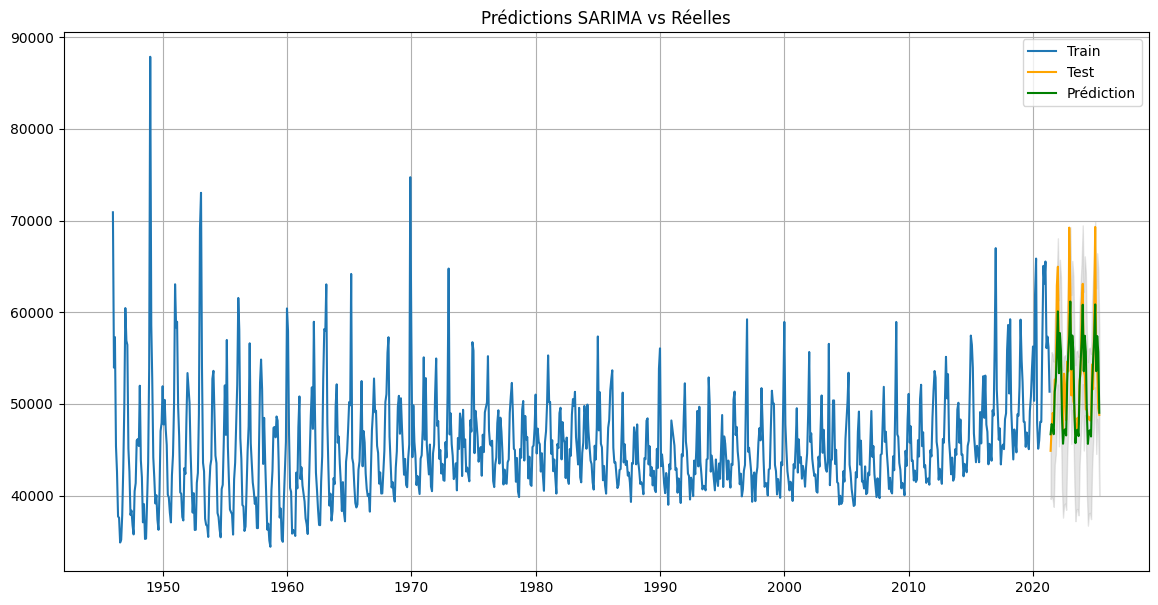

In [37]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
# 2. Entraînement du modèle (version optimisée)
def train_sarima(train_data):
    model = SARIMAX(
        train_data,
        order=(5, 0, 4),          # Ordre non-saisonnier
        seasonal_order=(2, 0, 1, 12),  # Ordre saisonnier
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    model_fit = model.fit(disp=False)
    return model_fit

# 3. Prédiction avec intervalle de confiance
def make_predictions(model, test_data):
    pred = model.get_forecast(steps=len(test_data))
    pred_mean = pred.predicted_mean
    pred_ci = pred.conf_int()
    return pred_mean, pred_ci

# 4. Évaluation
def evaluate(y_true, y_pred):
    metrics = {
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAPE': np.mean(np.abs((y_true - y_pred)/y_true))*100
    }
    return metrics

# 5. Visualisation
def plot_results(train, test, pred, pred_ci):
    plt.figure(figsize=(14, 7))
    plt.plot(train.index, train, label='Train')
    plt.plot(test.index, test, label='Test', color='orange')
    plt.plot(test.index, pred, label='Prédiction', color='green')
    plt.fill_between(test.index, 
                    pred_ci.iloc[:, 0], 
                    pred_ci.iloc[:, 1], 
                    color='gray', alpha=0.2)
    plt.title('Prédictions SARIMA vs Réelles')
    plt.legend()
    plt.grid()
    plt.show()

# Pipeline principal
if __name__ == "__main__":
    
    # Étape 2 (Alternative: utiliser le modèle déjà identifié)
    model = train_sarima(train)
    print(model.summary())
    
    # Étape 3
    predictions, pred_ci = make_predictions(model, test)
    
    # Étape 4
    metrics = evaluate(test, predictions)
    print("\nMétriques d'évaluation:")
    for k, v in metrics.items():
        print(f"{k}: {v:.2f}")
    
    # Étape 5
    plot_results(train, test, predictions, pred_ci)

In [36]:
df = df.sort_index()
df = df.asfreq('MS')
# 90% pour entraînement, 10% pour test
train_size = int(len(df) * 0.95)
train, test = df.iloc[:train_size], df.iloc[train_size:]